# Access GLCFS model output from THREDDS Server

This notebook is help users get started using FVCOM output from the [GLERL THREDDS Server](https://www.glerl.noaa.gov/thredds/catalog/catalog.html). This example includes data from the Great Lakes Coastal Forecasting System ([GLCFS](https://www.glerl.noaa.gov/res/glcfs/)). Learn more about [GLCFS here](https://www.glerl.noaa.gov/res/Programs/ipemf/GLCFS_nextgen.html) and how to access both experimental and operational data on the [Data Access page here](https://www.glerl.noaa.gov/res/Programs/ipemf/glcfs_data_access.html).

The Python modules used in this example are fairly common. We also provide examples using the module [PyFVCOM](https://github.com/pmlmodelling/pyfvcom).  More examples of PyFVCOM can be found [here](https://notebook.community/pwcazenave/PyFVCOM/examples/pyfvcom_plot_example).

Thank you those whose code we based this notebook from including Rich Signell USGS [avavilable here](https://nbviewer.org/github/rsignell-usgs/ipython-notebooks/blob/master/files/FVCOM_depth_and_velocity.ipynb) and Tristan Salles [available here](https://tristansalles.github.io/Coast/queryocean/oceanforecast.html).

In [1]:
import time

%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.tri as Tri
import matplotlib.pyplot as plt
import netCDF4
import datetime as dt
import pandas as pd
from io import StringIO


%config InlineBackend.figure_format = 'png'
plt.rcParams['mathtext.fontset'] = 'cm'

import warnings
warnings.filterwarnings('ignore')

## Loading the FVCOM file


In [2]:
# Set the URL
url = 'https://www.glerl.noaa.gov/thredds/dodsC/glcfs/erie/nowcast/042512_0001.nc'

# Load it via OPeNDAP
nc = netCDF4.Dataset(url)

# Query the variables
for var in nc.variables.keys() :
    print(var)

nprocs
partition
x
y
lon
lat
xc
yc
lonc
latc
siglay
siglev
siglay_center
siglev_center
h_center
h
nv
iint
time
Itime
Itime2
Times
zeta
nbe
ntsn
nbsn
ntve
nbve
a1u
a2u
aw0
awx
awy
art2
art1
u
v
tauc
omega
ww
ua
va
temp
salinity
viscofm
viscofh
km
kh
kq
q2
q2l
l
short_wave
net_heat_flux
sensible_heat_flux
latent_heat_flux
long_wave
uwind_speed
vwind_speed
wet_nodes
wet_cells
wet_nodes_prev_int
wet_cells_prev_int
wet_cells_prev_ext
aice
vice
tsfc
uuice
vvice


In [3]:
# take a look at the "metadata" for the variable "u"
print (nc.variables['u'])

<class 'netCDF4._netCDF4.Variable'>
float32 u(time, siglay, nele)
    long_name: Eastward Water Velocity
    standard_name: eastward_sea_water_velocity
    units: meters s-1
    grid: fvcom_grid
    type: data
    coordinates: time siglay latc lonc
    mesh: fvcom_mesh
    location: face
unlimited dimensions: time
current shape = (12, 20, 11509)
filling off


## Set FVCOM simulation time

In [4]:
# Enter your specific date & time in UTC
# This must correspond to the file you selected in the 'URL'
# variable above
start = dt.datetime(2023,4,25,12,0,0) # year,month,day,hour,minute,second

# Get desired time step  
time_var = nc.variables['time']
itime = netCDF4.date2index(start,time_var,select='nearest') 
print(itime, start)

11 2023-04-25 12:00:00


In [5]:
# Convert datetime format
dtime = netCDF4.num2date(time_var[itime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print(daystr)

2023-Apr-25 12:00


## Get specific data from FVCOM outputs

In [6]:
# Get lon,lat coordinates for nodes (depth)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

time.sleep(3) #this makes a three second pause in the code so THREDDS server has time to respond

In [7]:
# Get lon,lat coordinates for cell centers (depth)
latc = nc.variables['latc'][:]
lonc = nc.variables['lonc'][:]

time.sleep(3) #this makes a three second pause in the code so THREDDS server has time to respond

In [8]:
# Get depth
h = nc.variables['h'][:]

time.sleep(3) #this makes a three second pause in the code so THREDDS server has time to respond

In [9]:
# Get Connectivity array
nv = nc.variables['nv'][:].T - 1 

time.sleep(3) #this makes a three second pause in the code so THREDDS server has time to respond

In [10]:
# Take FVCOM Delaunay grid
tri = Tri.Triangulation(lon,lat,triangles=nv)

time.sleep(3) #this makes a three second pause in the code so THREDDS server has time to respond

## Find FVCOM velocity field

In [11]:
# Get current at layer [0 = surface, -1 = bottom]
ilayer = 0
u = nc.variables['u'][itime, ilayer, :]
v = nc.variables['v'][itime, ilayer, :]

## Visualize FVCOM forecast model

In [12]:
# Region to plot
# print(np.min(latc), np.max(latc))
# print(np.min(lonc), np.max(lonc))
ax = [np.min(lonc), np.max(lonc), np.min(latc), np.max(latc)]

# Find velocity points in bounding box
ind = np.argwhere((lonc >= ax[0]) & (lonc <= ax[1]) & (latc >= ax[2]) & (latc <= ax[3]))

In [13]:
# Depth contours to plot
max_depth = -int(max(nc.variables['h'][:])) - 1
levels=np.arange(max_depth,10,1)   

In [14]:
# To make the figure readable subsample the number of vector to draw.
subsample = 3
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

## Plot in iPython

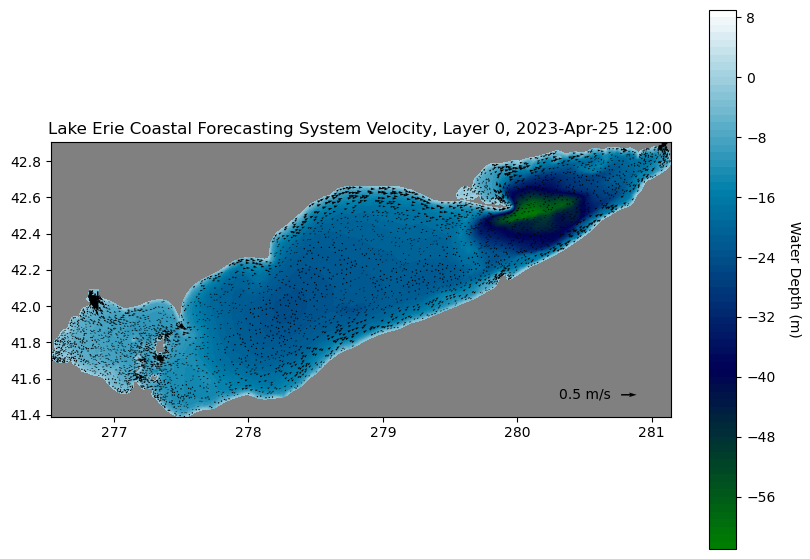

In [15]:
# tricontourf plot of water depth with vectors on top
fig1 = plt.figure(figsize=(10,7))

ax1 = fig1.add_subplot(aspect=(1.0/np.cos(np.mean(lat)*np.pi/180.0)))

# Water depth
plt.tricontourf(tri, -h, levels=levels, cmap=plt.cm.ocean)
plt.axis(ax)

ax1.patch.set_facecolor('0.5')
cbar=plt.colorbar()
cbar.set_label('Water Depth (m)', rotation=-90, labelpad=18)

# Quiver plot
Q = ax1.quiver(lonc[idv],latc[idv],u[idv],v[idv],scale=20)
qk = plt.quiverkey(Q,0.92,0.08,0.50,'0.5 m/s',labelpos='W')

plt.title('Lake Erie Coastal Forecasting System Velocity, Layer %d, %s' % (ilayer, daystr))
plt.show()

## Extract Temperature Profile

In [16]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Cleveland OH,   41.72883, -81.798497
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')
# Convert longitude coordinate
obs['Lon'] = 360.0 + obs['Lon']
obs

,Lat,Lon
Station,,
Cleveland OH,41.72883,278.201503


In [17]:
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    
    ind=np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
        
    return ind

# Query to find closest nodes to station locations
obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,NODE-ID
Station,,,
Cleveland OH,41.72883,278.201503,2736


In [18]:
# Get temperature profile from location named above
# At the time defined above
nsta=len(obs)
z=np.ones((len(nc.variables['siglay'][:,0]),nsta))

In [19]:
for i in range(len(obs)):
    # Find depth in meters of center of sigma layer
    depths=nc.variables['siglay'][:,obs['NODE-ID'][i]] * nc.variables['h'][obs['NODE-ID'][i]]
    z[:,i] = nc['temp'][0,:,obs['NODE-ID'][i]]

In [20]:
# Make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z[:],index=depths)
zvals.index.name = 'depth_m'
zvals.columns=['temp_C']

# Or print all values
print(zvals)

              temp_C
depth_m             
-0.531025   5.197840
-1.593075   5.215734
-2.655125   5.220207
-3.717175   5.222991
-4.779226   5.225032
-5.841276   5.226626
-6.903326   5.227908
-7.965375   5.228949
-9.027426   5.229790
-10.089477  5.230453
-11.151527  5.230949
-12.213576  5.231275
-13.275628  5.231416
-14.337677  5.231342
-15.399728  5.230993
-16.461779  5.230258
-17.523829  5.228909
-18.585876  5.226341
-19.647928  5.218775
-20.709980  5.188787


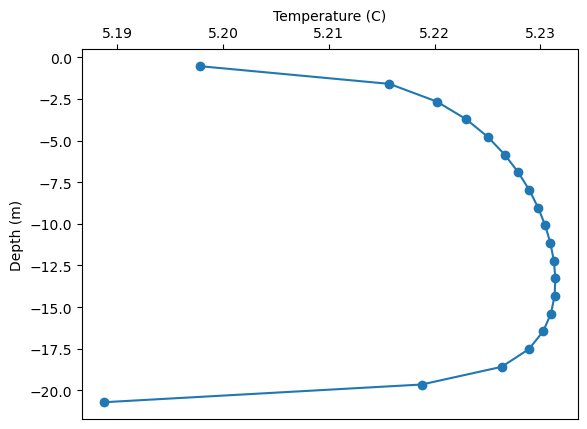

In [21]:
# Plot temperature profile

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(zvals['temp_C'],zvals.index,'o-')

# Draw x label
ax1.set_xlabel('Temperature (C)')
ax1.xaxis.set_label_position('top') # this moves the label to the top
ax1.xaxis.set_ticks_position('top') # this moves the ticks to the top

# Draw y label
ax1.set_ylabel('Depth (m)')

plt.show()

## Extract Current Profile

In [22]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Cleveland OH,   41.72883, -81.798497
'''
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station',engine='python')
# Convert longitude coordinate
obs['Lon'] = 360.0 + obs['Lon']
obs


,Lat,Lon
Station,,
Cleveland OH,41.72883,278.201503


In [23]:
# Same code as the temperature profile above with addition of 
# nearest cell center coordinate (e.g., 'latc' & 'lonc')
# Find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    
    ind=np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist=np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i]=dist.argmin()
        
    return ind

# Query to find closest NECOFS nodes to station locations
obs['NODE-ID'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
obs['NODE-ID-c'] = nearxy(nc['lonc'][:],nc['latc'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,NODE-ID,NODE-ID-c
Station,,,,
Cleveland OH,41.72883,278.201503,2736,5194


In [24]:
# Create empty lists to store u,v value information
nsta=len(obs)
sigma_layers = len(nc.variables['siglay'][:,0]) # number of depth layers
ui=np.ones((sigma_layers,nsta))
vi=np.ones((sigma_layers,nsta))

In [25]:
# Get u values profile from location named above
# At the time defined above
for i in range(nsta):
    ui[:,i] = nc['u'][itime,:,obs['NODE-ID-c'][i]]

In [26]:
# Get v values profile from location named above
# At the time defined above
for i in range(nsta):
    vi[:,i] = nc['v'][itime,:,obs['NODE-ID-c'][i]]

In [27]:
# Get depths nearest observation point
for i in range(nsta):
    depths=nc.variables['siglay'][:,obs['NODE-ID'][i]] * nc.variables['h'][obs['NODE-ID'][i]]

# Make a DataFrame out of the interpolated time series at each location
uvals=pd.DataFrame(ui[:],index=depths)
uvals.index.name = 'depth_m'
uvals.columns=['u']

vvals=pd.DataFrame(vi[:],index=depths)
vvals.index.name = 'depth_m'
vvals.columns=['v']

circ_profile = pd.concat([uvals, vvals], axis=1)

#Print all values
print(circ_profile)

                   u         v
depth_m                       
-0.531025   0.040028  0.026247
-1.593075   0.032888  0.015822
-2.655125   0.023069  0.004561
-3.717175   0.017605 -0.000708
-4.779226   0.013354 -0.004218
-5.841276   0.009766 -0.006768
-6.903326   0.006628 -0.008686
-7.965375   0.003832 -0.010146
-9.027426   0.001310 -0.011257
-10.089477 -0.000983 -0.012094
-11.151527 -0.003077 -0.012709
-12.213576 -0.004998 -0.013142
-13.275628 -0.006762 -0.013422
-14.337677 -0.008385 -0.013573
-15.399728 -0.009877 -0.013611
-16.461779 -0.011247 -0.013546
-17.523829 -0.012497 -0.013380
-18.585876 -0.013619 -0.013095
-19.647928 -0.014563 -0.012610
-20.709980 -0.014914 -0.011373
